In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.model_selection import train_test_split

from convexmtl_torch.model.ConvexTorchCombinator import ConvexTorchCombinator
from convexmtl_torch.model.GraphLaplacianTorchCombinator import GraphLaplacianTorchCombinator
from convexmtl_torch.model.utils import NeuralNetwork

from convexmtl_torch.data.MTLSyntheticDataset import MTLCommonRegression

import torch
from torch.nn import MSELoss
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from pytorch_lightning import Trainer

from icecream import ic

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random

from copy import copy


In [2]:
seed = 1

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [3]:
log_every_n_steps=10
problem = 'common'

In [4]:
mtlds = MTLCommonRegression(n_samples_per_task=100)

X, y = mtlds.X, mtlds.y

if y.ndim < 2:
    y = y[:, None]

ic| tasks: [0, 1, 2]
ic| colors: {0: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0),
             2: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)}
ic| X_data.shape: (300, 1)


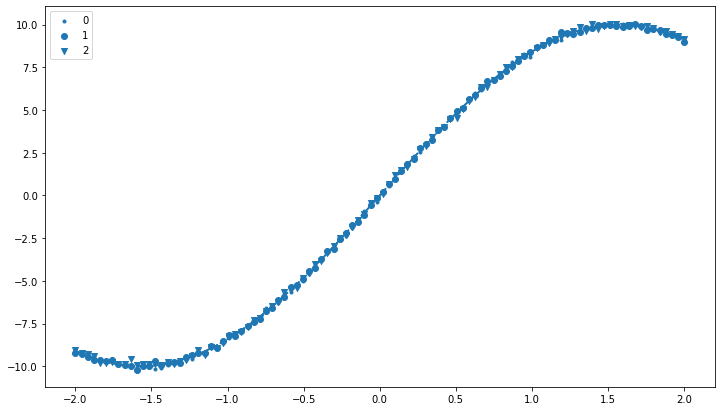

In [5]:
mtlds.plot_data_functions(X, y)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_test_numpy = copy(X_test)

In [7]:
X_train, t_train = X_train[:,:-1], X_train[:,-1].astype(int)
X_test, t_test = X_test[:,:-1], X_test[:,-1].astype(int)
X_train, t_train, y_train = map(torch.tensor, (X_train, t_train, y_train))
X_train, t_train, y_train = map(lambda obj: obj.float(), [X_train, t_train, y_train])
X_test, t_test, y_test = map(torch.tensor, (X_test, t_test, y_test))
X_test, t_test, y_test = map(lambda obj: obj.float(), [X_test, t_test, y_test])


In [8]:
tasks = np.unique(t_train)
n_tasks = len(tasks)

In [9]:
# train_ds = TensorDataset(X_train, t_train, y_train)
train_ds = TensorDataset(X_train, t_train, y_train)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)



In [10]:
X_train.shape

torch.Size([201, 1])

## GraphLaplacian Torch

In [11]:
max_epochs=50

In [12]:
model = GraphLaplacianTorchCombinator(n_features=1, n_output=1, n_channel=1, tasks=tasks, nu=0.1, mu=0.05, adj_lr=1e-2, log_matrix_freq=50)
# model = NeuralNetwork(n_features=1)

In [13]:
trainer = Trainer(max_epochs=max_epochs, log_every_n_steps=log_every_n_steps, default_root_dir='gl_{}_logs'.format(problem))

trainer.fit(model, train_dl)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
ic| opt_kwargs: {'lr': 0.001, 'weight_decay': 0.01}

  | Name           | Type                   | Params
----------------------------------------------------------
0 | common_module_ | NeuralNetworkFeatLearn | 8.4 K 
----------------------------------------------------------
8.4 K     Trainable params
0         Non-trainable params
8.4 K     Total params
0.034     Total estimated model params size (MB)
/home/carlos/anaconda3/envs/rkm/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/carlos/anaconda3/envs/rkm/lib/p

Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 20.55it/s, loss=0.205, v_num=20]

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|██████████| 7/7 [00:00<00:00, 18.25it/s, loss=0.205, v_num=20]


In [14]:
model.get_adjMatrix()

array([[9.99999762e-01, 9.74721246e-08, 9.75234542e-08],
       [9.74721246e-08, 9.99999762e-01, 9.77756400e-08],
       [9.75234542e-08, 9.77756400e-08, 9.99999762e-01]])

In [15]:
# pred = model(X_test, t_test)
pred = model(X_test, t_test)

In [16]:
pred_numpy = pred.detach().numpy()
pred_numpy.shape

(99, 1)

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mean_squared_error(pred_numpy, y_test.detach().numpy())

0.17398793

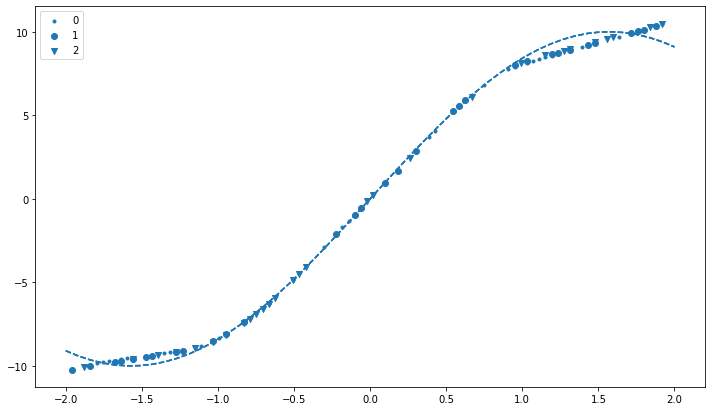

In [18]:
mtlds.plot_data_functions(X_test_numpy, pred_numpy)

In [19]:
adjMatrix = model.get_adjMatrix()

In [20]:
adjMatrix

array([[9.99999762e-01, 9.74721246e-08, 9.75234542e-08],
       [9.74721246e-08, 9.99999762e-01, 9.77756400e-08],
       [9.75234542e-08, 9.77756400e-08, 9.99999762e-01]])

<AxesSubplot:>

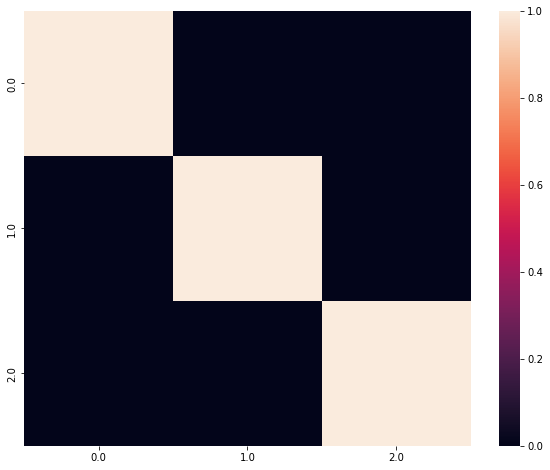

In [21]:
import seaborn as sns

plt.figure(figsize=(10, 8))
ax = plt.gca()
sns.heatmap(adjMatrix, xticklabels=tasks, yticklabels=tasks, vmin=0, vmax=1, ax=ax)

## tensorboard

In [22]:
%reload_ext tensorboard
%tensorboard --logdir=gl_common_logs/